# Regions

In [1]:
import copy
import json
import requests
import datetime as dt

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import plotly.graph_objects as go
import plotly.offline as pyo

from scipy.interpolate import interp1d
import scipy.stats as sps

import pyjags
import arviz as az

from IPython.display import clear_output, HTML, Markdown

pyo.init_notebook_mode()
%matplotlib inline

In [2]:
states = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     #usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()

In [3]:
days = states.index.get_level_values('data').unique()
regions = states.index.get_level_values('denominazione_regione').unique().sort_values()

In [4]:
print("FIRST ENTRY DATE: {}".format(
    days[0]
    )
)
print("LAST  ENTRY DATE: {}".format(
    days[-1]
    )
)
period = (days[-1] - days[0]).days

print("COVERAGE: {} days".format(period))
print("CURRENT DATE IS: {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

FIRST ENTRY DATE: 2020-02-24 18:00:00
LAST  ENTRY DATE: 2020-08-30 17:00:00
COVERAGE: 187 days
CURRENT DATE IS: 2020-08-31 15:33:25


# R<sub>t</sub> bayesian

Italy regions $R_t$ (effective reproduction number in time $t$) calculated with Bayesian approach ([Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) and [Kevin Systrom 2020](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)).

([read here for details](https://maxpierini.it/R0.pdf))

In [5]:
defined_p = [.95, .5]

In [6]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

In [7]:
np.seterr(all='ignore')

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, cutoff=1, filter_win=7, filter_std=2, smooth_win=14, smooth_std=5):

    cases[cases < 0] = 0

    cases, cases_outliers = hampel_filter_pandas(cases, filter_win, filter_std)
    
    smoothed = cases.rolling(smooth_win,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=smooth_std).round()
    smoothed[smoothed <= 0] = 0 #1e-10
    
    #idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[cutoff:]
    original = cases.loc[smoothed.index]
    
    return original, smoothed

def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = np.array([]), np.array([])
    j = 0
    while not lows.size or not highs.size:
        lows, highs = (total_p > (p-j)).nonzero()
        j += .05
        if j > 1:
            break
    
    if not len(lows):
        print("no lo")
        print(pmf)
        print(total_p)
        lows = np.array([0])
    if not len(highs):
        print("no hi")
        highs = np.array([1])
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    try:
        low = pmf.index[lows[best]]
    except Exception as err:
        print(f"lo{p} ERROR: {err}")
        low = 0
    try:
        high = pmf.index[highs[best]]
    except Exception as err:
        print(f"hi{p} ERROR: {err}")
        high = 1
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)[0]
    return {'indexes':idx, 'mass':HDImass, 'height':HDIheight}


def HDI_of_grid_from_df(pmf, p):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([HDI_of_grid_from_df(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    res = HDI_of_grid(pmf, p)
    #print(res["indexes"])
    lo_idx = res["indexes"][0]
    hi_idx = res["indexes"][-1]
    
    lo = pmf.index[lo_idx]
    hi = pmf.index[hi_idx]
    
    return pd.Series([lo, hi],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


def HDIs(pmf, P=[.95, .5]):
    RES = []
    for p in P:
        res = HDI_of_grid_from_df(pmf, p=p)
        RES.append(res)
    return RES

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    likelihoods[likelihoods==0] = 1e-15
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        #p_err = np.seterr(all='raise')
        #try:
        #    log_likelihood += np.log(denominator)
        #except Exception as err:
        #    print(f"log err {err} (d={denominator})")
        #    log_likelihood += np.log(1+1e-10)
        #np.seterr(**p_err)
    
    return posteriors, log_likelihood

# targets = ~states.index.get_level_values('denominazione_regione')
# states_to_process = states.loc[states]

#_results = {}

########################### SIGMAS ###########################
sigmas = np.linspace(1/20, 1, 20)

#for state_name, cases in states.groupby(level='denominazione_regione'):
#    print(f"log likelihoods for {state_name}...")
#    smoothed = []
#    cutoff = 20
#    while not len(smoothed):
#        new, smoothed = prepare_cases(cases, cutoff=cutoff)
#        cutoff -= 1
#    
#    result = {}
#    
#    # Holds all posteriors with every given value of sigma
#    result['posteriors'] = []
#    
#    # Holds the log likelihood across all k for each value of sigma
#    result['log_likelihoods'] = []
#    
#    for sigma in sigmas:
#        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
#        result['posteriors'].append(posteriors)
#        result['log_likelihoods'].append(log_likelihood)
#    
#    # Store all results keyed off of state name
#    _results[state_name] = result
#    #clear_output(wait=True)

########################### SIGMAS ###########################

sigma = .25

results = None

states_data = states['nuovi_positivi']

for name, cases in states_data.groupby(level='denominazione_regione'):
    #print(f"Rt {name}...")
    original, smoothed = prepare_cases(cases)
    #if name == "Sardegna":
    #    print(original)
    #    print(smoothed)
    #    plt.plot(original.values, ls=":", c="k")
    #    plt.plot(smoothed.values, ls="-", c="r")

    #sigmas = np.linspace(1/20, 1, 20)
    
    ## Each index of this array holds the total of the log likelihoods for
    ## the corresponding index of the sigmas array.
    #total_log_likelihoods = np.zeros_like(sigmas)
    #
    ## Loop through each state's results and add the log likelihoods to the running total.
    #for state_name, result in results.items():
    #total_log_likelihoods += _results[name]['log_likelihoods']
    #
    ## Select the index with the largest log likelihood total
    #max_likelihood_index = total_log_likelihoods.argmax()
    #
    ## Select the value that has the highest log likelihood
    #sigma = sigmas[max_likelihood_index]
    #print(f"sigma = {sigma}")
    
    # Note that we're fixing sigma to a value just for the example
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)

    # Note that this takes a while to execute - it's not the most efficient algorithm
    #hdis = highest_density_interval(posteriors, p=defined_p)
    HDIS = HDIs(posteriors, P=defined_p)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = most_likely
    for hdis in HDIS:
        result = pd.concat([result, hdis], axis=1)

    results = pd.concat([results, result])

#clear_output()

In [8]:
def plot_rt(result, ax, state_name, P=[.95, .5]):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,.75,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    update = results.index.get_level_values('data')[-1].date()
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=20,
               lw=.25,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                         end=index[-1]+pd.Timedelta(days=1))
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    for j, p in enumerate(P):
        lowfn = interp1d(date2num(index),
                         result[f'Low_{p*100:.0f}'].values,
                         bounds_error=False,
                         fill_value='extrapolate')

        highfn = interp1d(date2num(index),
                          result[f'High_{p*100:.0f}'].values,
                          bounds_error=False,
                          fill_value='extrapolate')



        ax.fill_between(extended,
                        lowfn(date2num(extended)),
                        highfn(date2num(extended)),
                        color='k',
                        alpha=.1*(j+1),
                        lw=0,
                        zorder=3+j)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-02-24'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    plt.suptitle(
        f"Italian Regions Real Time $R_t$ up to {update} (HDI {','.join([f'{p:.0%}' for p in sorted(P)])})", 
        fontsize=30, y=1.02)
    fig.set_facecolor('w')
    return values[-1]

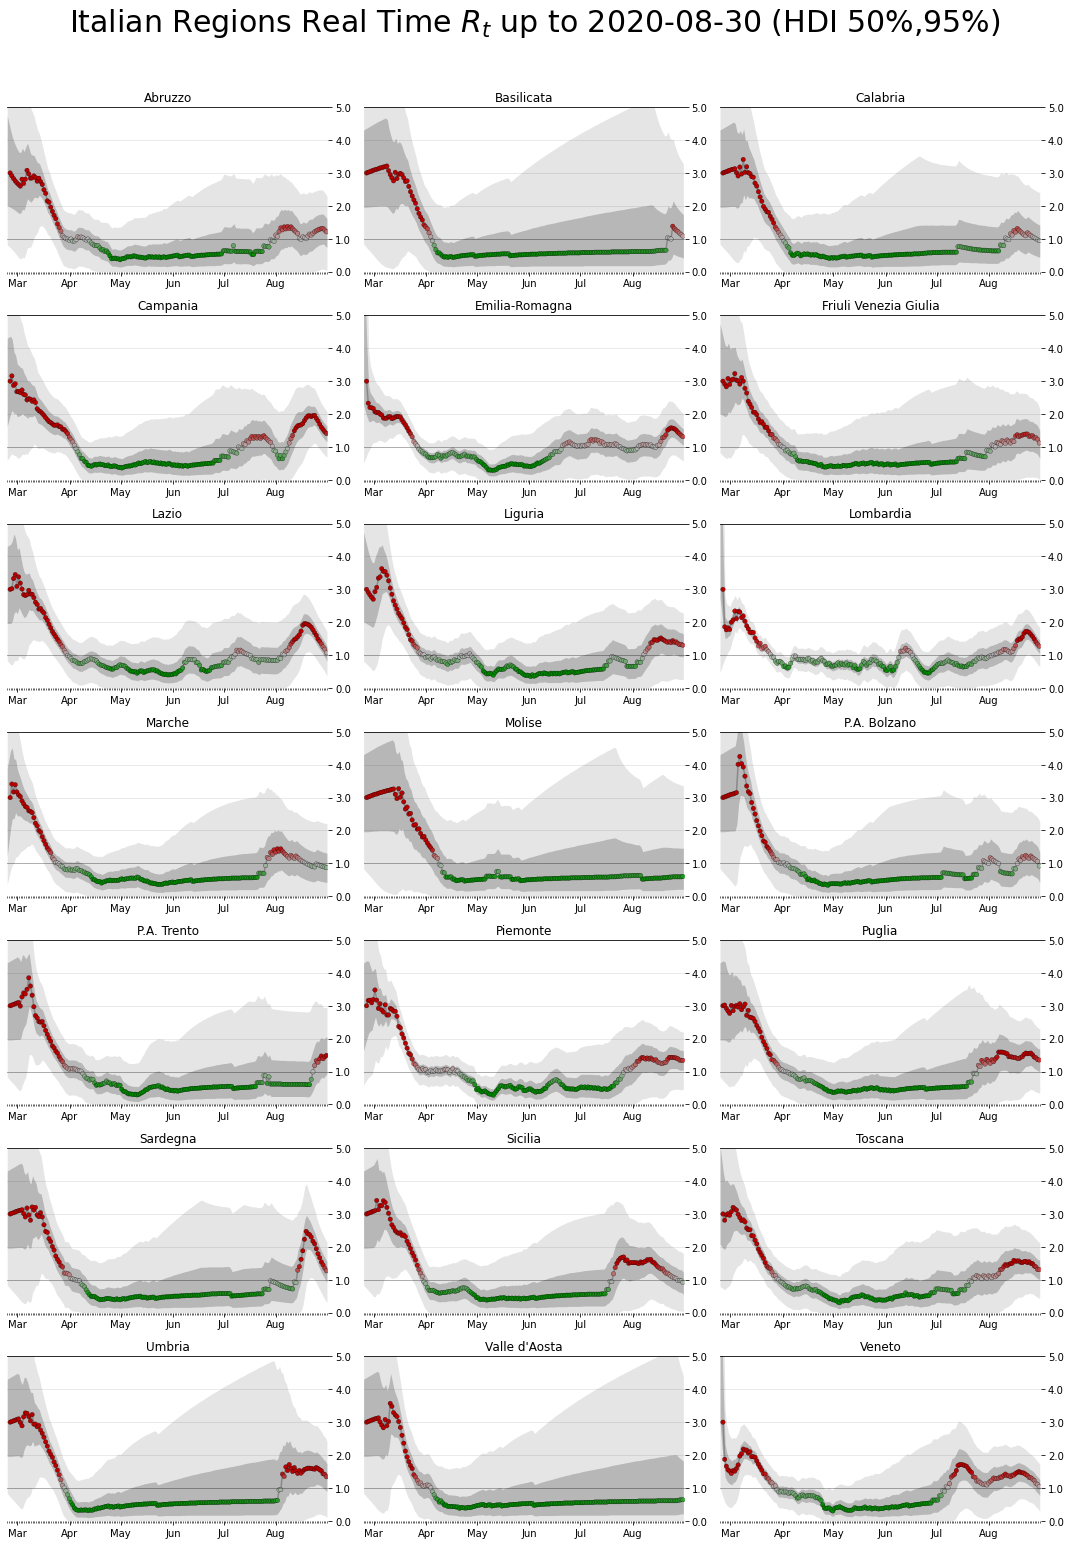

In [9]:
_R0 = {}
ncols = 3
nrows = 7

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

_ = """smr = results.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2)"""

for i, (state_name, result) in enumerate(results.groupby('denominazione_regione')):
    last_Rt = plot_rt(result, axes.flat[i], state_name, P=defined_p)
    _R0.update({state_name: last_Rt})

fig.tight_layout()
fig.set_facecolor('w')

with open("R0_regioni.json", "w") as f:
    json.dump(_R0, f)

In [10]:
results.to_pickle("Rt-regions-time-series.pkl")

***

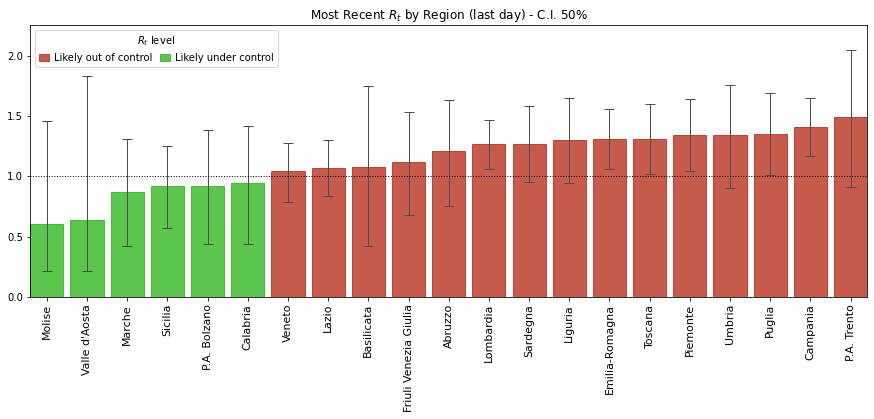

***

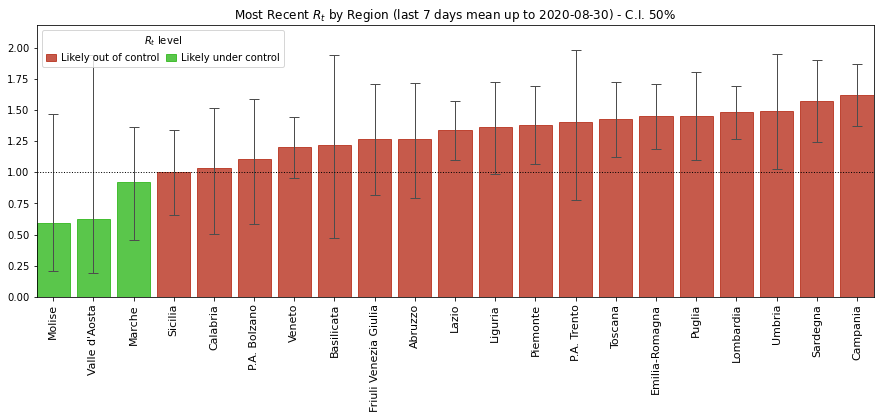

In [11]:
BO_COLOR = [.7,.7,.7]
NO_COLOR = [179/255,35/255,14/255,.75]
OK_COLOR = [.5,.5,.5]
KO_COLOR = [35/255,179/255,14/255,.75]
ERROR_BAR_COLOR = [.3,.3,.3]

def plot_standings(msr, figsize=None, p=.9, days=2):
    display(Markdown("***"))
    mr = msr.groupby(level=0)[['ML', f'High_{p*100:.0f}', f'Low_{p*100:.0f}']].tail(days)
    mr = mr.groupby("denominazione_regione")[['ML', f'High_{p*100:.0f}', f'Low_{p*100:.0f}']].mean()
    display(HTML(mr.to_html()))
    mr.sort_values('ML', inplace=True)
    update = results.index.get_level_values('data')[-1].date()
    
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    if days == 1:
        txt = "last day"
    else:
        txt = f"last {days} days mean up to {update}"
    ax.set_title(f'Most Recent $R_t$ by Region ({txt}) - C.I. {p:.0%}')
    
    err = mr[[f'Low_{p*100:.0f}', f'High_{p*100:.0f}']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(np.arange(mr.index.size),
                  mr['ML'],
                  width=.825,
                  color=BO_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=5,
                  error_kw={'alpha':1, 'lw':1},
                  yerr=err.values.T)

    for bar, ml, h90 in zip(bars, mr["ML"], mr[f"High_{p*100:.0f}"]):
        if ml > 1:
            bar.set_color(NO_COLOR)
        #if ml < .75:
        #    bar.set_color(OK_COLOR)
        if ml == 1:
            bar.set_color(BO_COLOR)
        if ml < 1:
            bar.set_color(KO_COLOR)

    labels = mr.index.unique().values  #.replace({'District of Columbia':'DC'})
    ax.set_xticks(np.arange(mr.index.size))
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,max(mr[f"High_{p*100:.0f}"])*1.1)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    ax.legend(handles=[
                        Patch(label='Likely out of control', color=NO_COLOR),
                        #Patch(label='Unsure', color=BO_COLOR),
                        #Patch(label='Near 0', color=OK_COLOR),
                        Patch(label='Likely under control', color=KO_COLOR)
                    ],
                    title='$R_t$ level',
                    ncol=2,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    #leg._legend_box.align = "left"
    fig.set_facecolor('w')
    plt.show()
    plt.close(fig="all")
    return fig, ax

plot_standings(results, figsize=(15,5), p=min(defined_p), days=1);
plot_standings(results, figsize=(15,5), p=min(defined_p), days=7);

# Growths

Read here for current method [PDF](https://maxpierini.it/ncov/italy-regions-exp-new.pdf).

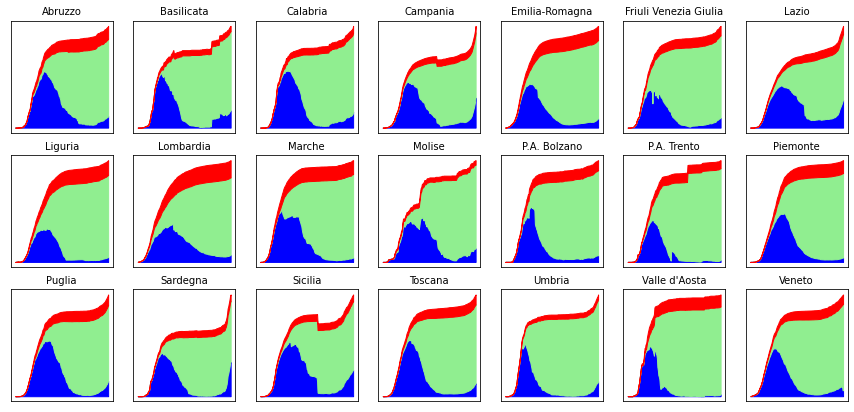

In [12]:
with open("priors.npy", "rb") as f:
    bartlett_samples = np.load(f)

fig, ax = plt.subplots(3, 7, figsize=(15,7))

for i, state in enumerate(states.index.get_level_values('denominazione_regione').unique()):
    f = states.loc[state]
    I = f['totale_positivi']
    R = f['dimessi_guariti']
    D = f['deceduti']
    ax.flat[i].set_title(state, fontsize=10)
    ax.flat[i].fill_between(
        days,
        0, I, color="b"
    )
    ax.flat[i].fill_between(
        days,
        I, R+I, color="lightgreen"
    )
    ax.flat[i].fill_between(
        days,
        R+I, R+I+D, color="r"
    )
    ax.flat[i].set_xticks([])
    ax.flat[i].set_yticks([])

In [13]:
def slope(x, y0, yz):
    alpha = (yz - y0) / (x.size - 1)
    return alpha

def exp_unif(x, beta, y0, yz):
    with np.errstate(all='ignore'):
        y = np.nan_to_num((np.exp(beta * x) - 1)/(np.exp(beta) - 1))
        y = y * (yz - y0) + y0
        
    alpha = slope(x, y0, yz)

    return (y, alpha)

window = 14
x = np.linspace(0, 1, window)

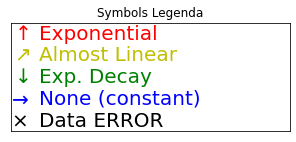

In [14]:
fig, ax = plt.subplots(figsize=(5,2))
ax.text(0, .1, r"$\times$", color="k", fontsize=20, ha='left', va='center')
ax.text(0, .3, r"$\to$", color="b", fontsize=20, ha='left', va='center')
ax.text(0, .5, r"$\downarrow$", color="g", fontsize=20, ha='left', va='center')
ax.text(0, .7, r"$\nearrow$", color="y", fontsize=20, ha='left', va='center')
ax.text(0, .9, r"$\uparrow$", color="r", fontsize=20, ha='left', va='center')

ax.text(.1, .1, "Data ERROR", color="k", fontsize=20, ha='left', va='center')
ax.text(.1, .3, "None (constant)", color="b", fontsize=20, ha='left', va='center')
ax.text(.1, .5, "Exp. Decay", color="g", fontsize=20, ha='left', va='center')
ax.text(.1, .7, "Almost Linear", color="y", fontsize=20, ha='left', va='center')
ax.text(.1, .9, "Exponential", color="r", fontsize=20, ha='left', va='center')

ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Symbols Legenda")
plt.show()
plt.close(fig="all")

## deceduti

### beta

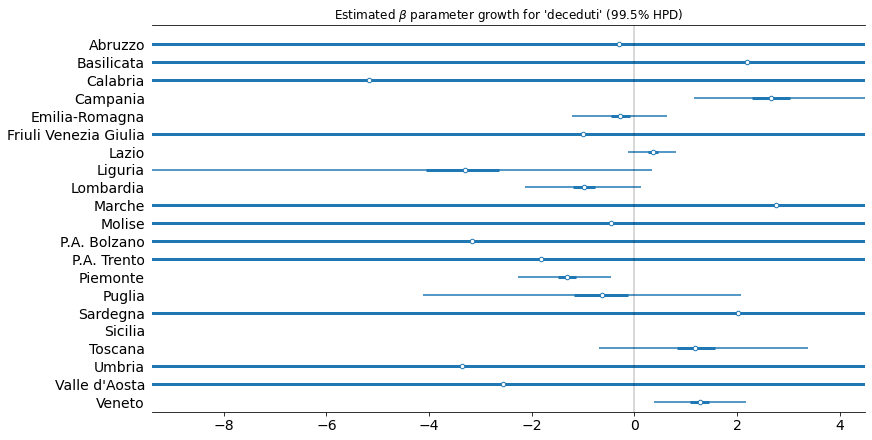

### fitted

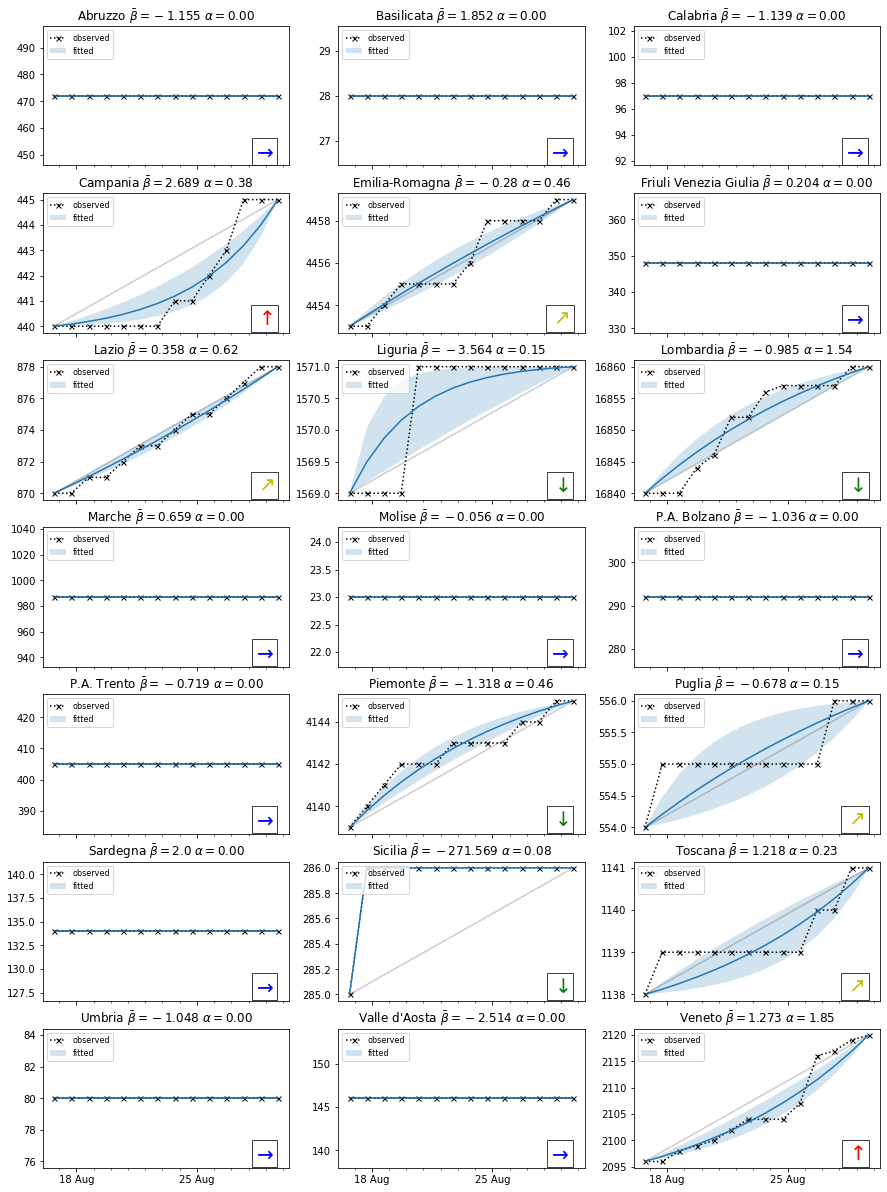

## totale_casi

### beta

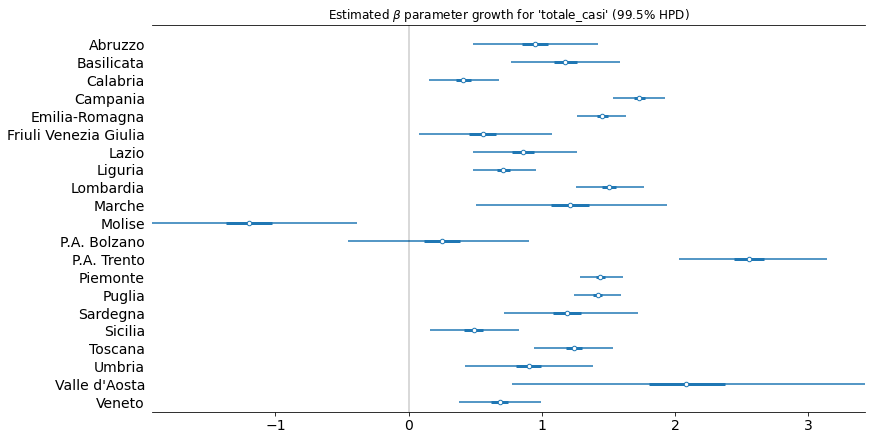

### fitted

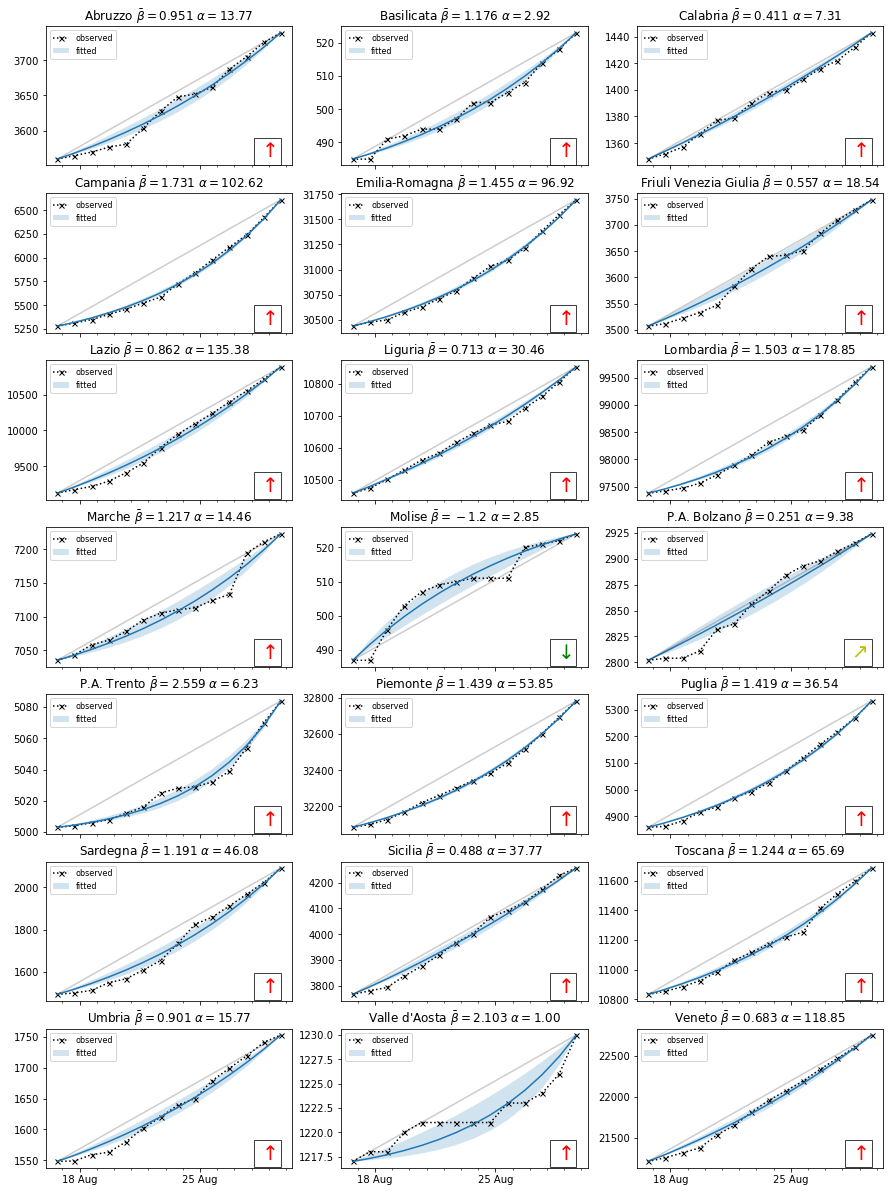

## Summary

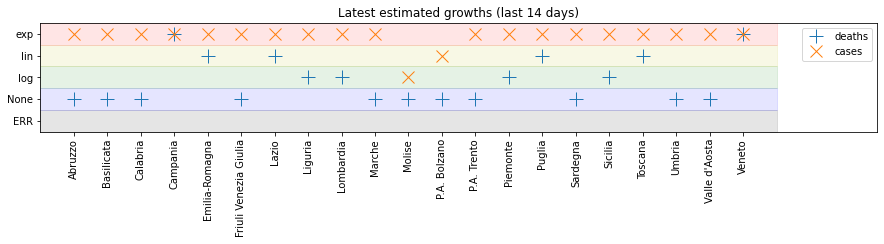

Growths summary:


For cumulative total cases

- 19 regions 90.48% are likely exponentially growing
- 1 regions 4.76% are likely almost linearly growing
- 1 regions 4.76% are likely exponentially decaying
- 0 regions 0.00% are likely constant

For cumulative total deaths:

- 2 regions 9.52% are likely exponentially growing
- 4 regions 19.05% are likely almost linearly growing
- 4 regions 19.05% are likely exponentially decaying
- 11 regions 52.38% are likely constant


In 90% regions, cases
are growing exponetially and in 5%
the situation is likely solved or about to resolution (no growth or exponential decay).

On the other hand, in 71% regions
deaths are not growing or decaying and 10%
are showing an exponential growth of deaths.

Linearly growing regions (5% for cases and
19% for deaths) situation is not severe but likely
not currently resolving.


In [15]:
beta_lim = 487

modelString = f"""
model {{
  for ( r in 1:R ) {{
    # inverse gamma variance
    tau[r] ~ dgamma( 0.001 , 0.001 )
    sigma[r] <- 1 / sqrt( tau[r] )
    # beta priors
    beta[r] ~ dunif( -{beta_lim} , {beta_lim} )
    
    for ( t in 1:W ) {{
      # define lim(beta->0)
      H[r,t] <- ( exp( beta[r] * x[t] ) - 1 )
      f[r,t] <- ifelse( nu[r] == 1 , x[t] , H[r,t] / nu[r] )
      # expected and observed
      E[r,t] <- f[r,t] * (yw[r] - y1[r]) + y1[r]
      y[r,t] ~ dnorm( E[r,t] , tau[r] )
    }}
    
    # define lim(beta->0)
    nu[r] <- ifelse( exp( beta[r] ) - 1 == 0 , 1 , exp( beta[r] ) - 1 )
  }}
}}
"""

df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'totale_casi', 'deceduti'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

countries = df.index.get_level_values("denominazione_regione").unique().sort_values()
days = df.index.get_level_values("data").unique()

w_min = -window-1
w_max = -1

growth = {}

for what in df.columns:
    display(Markdown(f"## {what}"))
    growth.update({
        (what, 'x'): {},
        (what, 'growth'): {},
        (what, 'beta'): {},
        (what, 'alpha'): {},
    })
    y = np.array([])
    Y = np.array([])
    beta_lims = np.array([])
    for country in countries:
        growth[(what, 'x')].update({country: None})
        growth[(what, 'growth')].update({country: None})
        growth[(what, 'beta')].update({country: "-"})
        growth[(what, 'alpha')].update({country: "-"})
        T = df.loc[country][what][w_min:w_max].values
        _T = copy.deepcopy(T)
        if _T[0] > _T[-1]:
            _T = _T[0] * np.ones(window)
        if not y.size:
            Y = copy.deepcopy(T)
            y = copy.deepcopy(_T)
        else:
            Y = np.vstack([Y, T])
            y = np.vstack([y, _T])
        
    model_data = {
        "R": countries.size,
        "W": window,
        "x": x,
        "y": y,
        "y1": y[:,0],
        "yw": y[:,window-1],
    }
    jags_posterior_model = pyjags.Model(
        code=modelString, 
        data=model_data, 
        chains=4, 
        adapt=2000,
        progress_bar=False
    )

    #_ = jags_posterior_model.sample(2000, vars=["beta", "sigma"])
    
    jags_posterior_samples = jags_posterior_model.sample(8000, vars=["beta", "sigma"])
    
    pyjags_data = az.from_pyjags(jags_posterior_samples)

    summary = az.summary(pyjags_data, var_names="^beta", filter_vars="regex", hdi_prob=.99, kind="stats")
    summary_diag = az.summary(pyjags_data, var_names="^beta", filter_vars="regex", hdi_prob=.99, kind="diagnostics")
    
    sigma_smry = az.summary(pyjags_data, var_names="^sigma", filter_vars="regex", hdi_prob=.99, kind="stats")
    sigma_smry_diag = az.summary(pyjags_data, var_names="^sigma", filter_vars="regex", hdi_prob=.99, kind="diagnostics")
    
    #display(Markdown(f"### sigma"))
    
    _ = """for i, par in enumerate(sigma_smry.index):
        axs = az.plot_trace(
            pyjags_data.posterior.sigma[:,:,i],
            figsize=(20,2)
        )
        for j, ax in enumerate(axs):
            ax[j].set_title(f"sigma\n{countries[i]}")
        plt.show()
        plt.close(fig="all")
    
    axs = az.plot_density(
        pyjags_data.posterior.sigma,
        hdi_prob=.995,
        point_estimate="mode",
        figsize=(20,2*7)
    )
    for i, ax in enumerate(axs):
        ax.set_title(f"sigma\n{countries[i]}")
    plt.show()
    plt.close(fig="all")"""
    
    _ = """ax = az.plot_forest(
        pyjags_data, combined=True,
        var_names="^sigma",
        filter_vars="regex",
        hdi_prob=.995,
        figsize=(12,6),
    )
    ax[0].axvline(0, c="k", alpha=.2)
    ax[0].set_yticklabels(countries[::-1])
    ax[0].set_title(fr"Estimated $\sigma$ for '{what}' (99.5% HPD)")
    plt.show()
    plt.close(fig="all")
    
    display(HTML(sigma_smry.set_index(countries).to_html()))"""
    #display(Latex(sigma_smry_diag.set_index(countries).to_latex(longtable=True, )))
    
    display(Markdown(f"### beta"))
    
    _ = """for i, par in enumerate(summary.index):
        axs = az.plot_trace(
            pyjags_data.posterior.beta[:,:,i],
            figsize=(20,2)
        )
        for j, ax in enumerate(axs):
            ax[j].set_title(f"beta\n{countries[i]}")
        plt.show()
        plt.close(fig="all")
    
    axs = az.plot_density(
        pyjags_data.posterior.beta,
        hdi_prob=.995,
        figsize=(20,2*7)
    )
    for i, ax in enumerate(axs):
        ax.set_title(f"beta\n{countries[i]}")
    plt.show()
    plt.close(fig="all")"""

    beta_smry = summary[(summary["hdi_0.5%"]>-beta_lim*.5) & (summary["hdi_99.5%"]<beta_lim*.5)]
    
    ax = az.plot_forest(
        pyjags_data, combined=True,
        var_names="^beta",
        filter_vars="regex",
        hdi_prob=.995,
        figsize=(12,6),
    )
    ax[0].set_xlim(beta_smry["hdi_0.5%"].min(), beta_smry["hdi_99.5%"].max())
    ax[0].axvline(0, c="k", alpha=.2)
    ax[0].set_yticklabels(countries[::-1])
    ax[0].set_title(fr"Estimated $\beta$ parameter growth for '{what}' (99.5% HPD)")
    plt.show()
    plt.close(fig="all")
    
    display(HTML(summary.set_index(countries).to_html()))
    #display(Latex(summary_diag.set_index(countries).to_latex(longtable=True, )))
    
    display(Markdown(f"### fitted"))
    fig, ax = plt.subplots(7, 3, figsize=(15, 3*7), sharex=True)
    for par in range(countries.size):
        y1 = Y[par,0]
        yw = Y[par,-1]
        
        mu = summary.loc[f"beta[{par}]"]["mean"]
        lo = summary.loc[f"beta[{par}]"]["hdi_0.5%"]
        hi = summary.loc[f"beta[{par}]"]["hdi_99.5%"]
        sd = summary.loc[f"beta[{par}]"]["sd"]
        
        prmu, alpha = exp_unif(x, mu, y1, yw)
        prlo, _ = exp_unif(x, lo, y1, yw)
        prhi, _ = exp_unif(x, hi, y1, yw)
        
        bartlett_s, bartlett_p = sps.bartlett(
            bartlett_samples, 
            pyjags_data.posterior.beta[0,:,par].values.flatten(),
            pyjags_data.posterior.beta[1,:,par].values.flatten(),
            pyjags_data.posterior.beta[2,:,par].values.flatten(),
            pyjags_data.posterior.beta[3,:,par].values.flatten()
        )
        
        if yw < y1:
            growth[(what, 'x')][countries[par]] = -1
            growth[(what, 'growth')][countries[par]] = "ERR"
            txt = r"$\times$"
            col = "k"
        elif bartlett_p >= .05:
            # constant
            growth[(what, 'x')][countries[par]] = 0
            growth[(what, 'growth')][countries[par]] = "None"
            growth[(what, 'beta')][countries[par]] = 0
            growth[(what, 'alpha')][countries[par]] = 0
            txt = r"$\to$"
            col = "b"
        else:
            growth[(what, 'beta')][countries[par]] = f"{mu:.2f}"
            growth[(what, 'alpha')][countries[par]] = f"{alpha:.2f}"
            if lo <= 0 <= hi:
                # linear
                growth[(what, 'x')][countries[par]] = 2
                growth[(what, 'growth')][countries[par]] = "lin"
                txt = r"$\nearrow$"
                col = "y"
            # exp or dec
            elif mu < 0:
                # dec
                growth[(what, 'x')][countries[par]] = 1
                growth[(what, 'growth')][countries[par]] = "dec"
                txt = r"$\downarrow$"
                col = "g"
            else:
                # exp
                growth[(what, 'x')][countries[par]] = 3
                growth[(what, 'growth')][countries[par]] = "exp"
                txt = r"$\uparrow$"
                col = "r"
        
        ax.flat[par].plot(days[w_min:w_max], Y[par], 'x:', c="k", ms=5, label="observed")
        ax.flat[par].plot(days[w_min:w_max], prmu)
        ax.flat[par].fill_between(
            days[w_min:w_max], prlo, prhi, alpha=.2, label="fitted"
        )
        ax.flat[par].text(
            .9, .1, txt, color=col,
            fontsize=20, ha='center', va='center', transform=ax.flat[par].transAxes,
            bbox={'facecolor': 'w', 'alpha': .75, 'edgecolor': 'k'}
        )
        ax.flat[par].plot(
            days[w_min:w_max], alpha * np.arange(window) + y1, c="k", alpha=.2
        )
        ax.flat[par].set_title(fr"{countries[par]} $\bar{{\beta}}={mu}$ $\alpha={alpha:.2f}$")
        ax.flat[par].xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.flat[par].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
        ax.flat[par].xaxis.set_minor_locator(mdates.DayLocator())
        ax.flat[par].legend(fontsize=8, loc="upper left")
    plt.show()
    plt.close(fig="all")

growth_df = pd.DataFrame(growth)

display(Markdown(f"## Summary"))
fig, ax = plt.subplots(figsize=(15,2))

ax.plot(growth_df[('deceduti', 'x')],
    "+-", lw=0, ms=14,
    label="deaths"
)
ax.plot(growth_df[('totale_casi', 'x')],
    "x-", lw=0, ms=12,
    label="cases"
)
ax.set_title(f"Latest estimated growths (last {window} days)")
ax.set_xlim(-1, countries.size+3)
ax.set_ylim(-1.5, 3.5)
ax.set_xticks(np.arange(0, countries.size))
ax.set_xticklabels(countries, rotation=90)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(["ERR", "None", "log", "lin", "exp"])
ax.fill_between(
    np.arange(-1, countries.size+1), -1.5, -0.5, color="k", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), -0.5, 0.5, color="b", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), 0.5, 1.5, color="g", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), 1.5, 2.5, color="y", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), 2.5, 3.5, color="r", alpha=.1
)
ax.legend()
plt.show()
plt.close(fig="all");

display(Markdown('Growths summary:'))

display(HTML(growth_df.to_html(columns=[
    ('deceduti','growth'), ('deceduti','beta'), ('deceduti','alpha'),
    ('totale_casi','growth'), ('totale_casi','beta'), ('totale_casi','alpha'),
])))

display(Markdown("""

"""))

smry = pd.DataFrame(
    {
        'ERR': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==-1].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==-1].count(),
         },
        'None': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==0].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==0].count(),
         },
        'dec': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==1].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==1].count(),
         },
        'lin': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==2].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==2].count(),
         },
        'exp': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==3].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==3].count(),
         },
    }
)

display(HTML(smry.to_html()))

display(Markdown(fr"""
For cumulative total cases

- {smry.loc["cases"]["exp"]} regions {smry.loc["cases"]["exp"]/21:.2%} are likely exponentially growing
- {smry.loc["cases"]["lin"]} regions {smry.loc["cases"]["lin"]/21:.2%} are likely almost linearly growing
- {smry.loc["cases"]["dec"]} regions {smry.loc["cases"]["dec"]/21:.2%} are likely exponentially decaying
- {smry.loc["cases"]["None"]} regions {smry.loc["cases"]["None"]/21:.2%} are likely constant

For cumulative total deaths:

- {smry.loc["deaths"]["exp"]} regions {smry.loc["deaths"]["exp"]/21:.2%} are likely exponentially growing
- {smry.loc["deaths"]["lin"]} regions {smry.loc["deaths"]["lin"]/21:.2%} are likely almost linearly growing
- {smry.loc["deaths"]["dec"]} regions {smry.loc["deaths"]["dec"]/21:.2%} are likely exponentially decaying
- {smry.loc["deaths"]["None"]} regions {smry.loc["deaths"]["None"]/21:.2%} are likely constant


In {smry.loc["cases"]["exp"]/21:.0%} regions, cases
are growing exponetially and in {(smry.loc["cases"]["dec"]+smry.loc["cases"]["None"])/21:.0%}
the situation is likely solved or about to resolution (no growth or exponential decay).

On the other hand, in {(smry.loc["deaths"]["dec"]+smry.loc["deaths"]["None"])/21:.0%} regions
deaths are not growing or decaying and {smry.loc["deaths"]["exp"]/21:.0%}
are showing an exponential growth of deaths.

Linearly growing regions ({smry.loc["cases"]["lin"]/21:.0%} for cases and
{smry.loc["deaths"]["lin"]/21:.0%} for deaths) situation is not severe but likely
not currently resolving.
"""))

***

# Overview

## Cases

In [16]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['totale_casi'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (cases)", "xanchor": "center", "x": 0.5},
    yaxis_title="cases",
)

pyo.iplot(fig)

<hr>

## Deaths

In [17]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['deceduti'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (deaths)", "xanchor": "center", "x": 0.5},
    yaxis_title="deaths",
)

pyo.iplot(fig)

<hr>

## Recovered

In [18]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['dimessi_guariti'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (recovered)", "xanchor": "center", "x": 0.5},
    yaxis_title="recovered",
)

pyo.iplot(fig)

<hr>

## Positive

In [19]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['totale_positivi'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (positive)", "xanchor": "center", "x": 0.5},
    yaxis_title="infected",
)

pyo.iplot(fig)

<hr>

## Letality Rate

!!! PLEASE NOTE !!!

These rates are only useful for **SIRD** epidemiological model ([read here for details](https://maxpierini.it/R0.pdf)) not to define COVID-19 actual rates.

In [20]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['deceduti']/states.loc[region]['totale_casi'],
        mode='lines+markers',
        marker_size=3, marker_symbol="cross",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.2%}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696', "tickformat": ',.0%',},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (letality rate)", "xanchor": "center", "x": 0.5},
    yaxis_title="percentage",
)

pyo.iplot(fig)

## Recovery rate

In [21]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['dimessi_guariti']/states.loc[region]['totale_casi'],
        mode='lines+markers',
        marker_size=3, marker_symbol="cross",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.2%}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696', "tickformat": ',.0%',},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (recovery rate)", "xanchor": "center", "x": 0.5},
    yaxis_title="percentage",
)

pyo.iplot(fig)

## Hospitalized

In [22]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['terapia_intensiva'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (intensive care)", "xanchor": "center", "x": 0.5},
    yaxis_title="number",
)

pyo.iplot(fig)

In [23]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['ricoverati_con_sintomi'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (symptomatic hospitalized)", "xanchor": "center", "x": 0.5},
    yaxis_title="number",
)

pyo.iplot(fig)

In [24]:
fig = go.Figure()

for region in regions:
    fig.add_trace(go.Scatter(
        x=days, y=states.loc[region]['isolamento_domiciliare'],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(days.size)]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (home isolated)", "xanchor": "center", "x": 0.5},
    yaxis_title="number",
)

pyo.iplot(fig)